# Design CTP-10 Aire DNA-MERFISH library for all super enhancers

by Pu Zheng

2021.4.5

Super-enhancers are called by ...

# Table of contents


> 0. [Minimum required packages and settings](#0)
>>
>> 0.1: [import required packages](#0.1)
>
> 1. [Extract region sequences](#1)

<a id='0.1'></a>
## 0.1 load required packages

In [3]:
%run "..\..\Startup_py3.py"
sys.path.append(r"..\..\..\..\Documents")

import ImageAnalysis3 as ia
%matplotlib notebook

from ImageAnalysis3 import *
print(os.getpid())

# library design specific tools
from ImageAnalysis3.library_tools import LibraryDesigner as ld
from ImageAnalysis3.library_tools import LibraryTools as lt
# biopython imports
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio.Blast.Applications import NcbiblastnCommandline
from Bio.Blast import NCBIXML

36548


<a id='1'></a>
# 1 Extract region sequences

In [4]:
## Some folders
# human genome
reference_folder = r'\\10.245.74.212\Chromatin_NAS_2\Libraries\Genomes\mouse\GRCm38_ensembl'
genome_folder = os.path.join(reference_folder, 'Genome')
# Library directories
pool_folder = r'\\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire'

In [5]:
resolution = 0
flanking = 10000
# folder for sub-pool
library_folder = os.path.join(pool_folder, f'Genes_TSS_DNA')
if not os.path.exists(library_folder):
    print(f"create library folder: {library_folder}")
    os.makedirs(library_folder)
# folder for fasta sequences
sequence_folder = os.path.join(library_folder, 'sequences')
if not os.path.exists(sequence_folder):
    print(f"create sequence folder: {sequence_folder}")
    os.makedirs(sequence_folder)
# folder to save result probes
report_folder = os.path.join(library_folder, 'reports')
if not os.path.exists(report_folder):
    print(f"create report folder: {report_folder}")
    os.makedirs(report_folder)
    
print(f"-- library_folder: {library_folder}")
print(f"-- sequence_folder: {sequence_folder}")
print(f"-- report_folder: {report_folder}")

-- library_folder: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_TSS_DNA
-- sequence_folder: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_TSS_DNA\sequences
-- report_folder: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_TSS_DNA\reports


## 1.1 load gene list

In [6]:
gene_list_folder = os.path.join(pool_folder, 'Gene_list')
gene_list_filename = os.path.join(gene_list_folder, 'uniqued_clustered_genes_for_yuan_2021-04-22.txt')

In [7]:
import pandas as pd
gene_df = pd.read_csv(gene_list_filename, delimiter = "\t", header=None)
gene_df.columns = ['Cluster', 'Gene']

In [8]:
gene_df

,Cluster,Gene
0,Immature MEC,Ccl21a
1,Immature MEC,Krt14
2,Immature MEC,Krt5
3,Immature MEC,Col6a1
4,Immature MEC,Lifr
...,...,...
204,Aire-stage,Ltf
205,Aire-stage,Clps
206,Aire-stage,Col1a1
207,Aire-stage,Gpx6


In [53]:
# load gene reference
reload(library_tools.references)
reload(library_tools.sequences)
ref_filename = os.path.join(reference_folder, 'Transcriptome', 'Mus_musculus.GRCm38.102.chr.gff3')
with library_tools.references.gff3_reader(ref_filename, auto_read=False, load_savefile=True) as ref_rd:
    ## example commands
    #infos = _handle.load_all()
    #ref_rd._load_headers()
    #gene_infos = ref_rd.load_gene_by_id('ENSMUSG00000064842')
    #gene_dict = ref_rd.parse_gene_info(gene_infos)
    #gene_info_dict = ref_rd._batch_parse_gene_info()
    ref_save_dict = ref_rd._save_to_file(overwrite=False)
# searching example
matched_gene = ref_rd._search_gene_by_id('gene:ENSMUSG00000089613')
print(matched_gene[0]['infos']['Name'])
matched_gene = ref_rd._search_gene_by_name('Ccl21a')
print(matched_gene[0]['infos']['ID'])

- loading from save_file: \\10.245.74.212\Chromatin_NAS_2\Libraries\Genomes\mouse\GRCm38_ensembl\Transcriptome\Mus_musculus.GRCm38.102.chr.pkl
opening ref_file: \\10.245.74.212\Chromatin_NAS_2\Libraries\Genomes\mouse\GRCm38_ensembl\Transcriptome\Mus_musculus.GRCm38.102.chr.gff3


In [60]:
from tqdm.notebook import tqdm

In [64]:
gene_dicts = []
for _gene in tqdm(gene_df['Gene']):
    if _gene == 'Lect1': # there is one gene that actually has different name
        _gene = "Cnmd" 
    _gds = ref_rd._search_gene_by_name(_gene)
    if len(_gds) == 1:
        gene_dicts.append(_gds[0])
    else:
        print(_gene)

  0%|          | 0/209 [00:00<?, ?it/s]

In [111]:
# convert reg_dict into reg_start_dict
reg_dicts = [library_tools.sequences.gene_dict_2_reg_dict(_gd) for _gd in gene_dicts]
tss_dicts = []
reg_size = 10000
for _rd in reg_dicts:
    _tss_d = {_k:_v for _k,_v in _rd.items()}
    if _tss_d['Strand'] == '+':
        _tss_d["Start"] = int(_rd['Start']) - int(reg_size/2)
        _tss_d["End"] = int(_rd['Start']) + int(reg_size/2)
        _tss_d['Region'] = f"{_rd['Chr']}:{_tss_d['Start']}-{_tss_d['End']}"
    else:
        _tss_d["Start"] = int(_rd['End']) - int(reg_size/2)
        _tss_d["End"] = int(_rd['End']) + int(reg_size/2)
        _tss_d['Region'] = f"{_rd['Chr']}:{_tss_d['Start']}-{_tss_d['End']}"
    # append
    tss_dicts.append(_tss_d)

In [112]:
reg_dicts[0], tss_dicts[0]

({'Chr': '4',
  'Start': '42772860',
  'End': '42773993',
  'Name': 'gene:ENSMUSG00000094686-Ccl21a',
  'Gene': 'Ccl21a',
  'Region': '4:42772860-42773993',
  'Strand': '-'},
 {'Chr': '4',
  'Start': 42768993,
  'End': 42778993,
  'Name': 'gene:ENSMUSG00000094686-Ccl21a',
  'Gene': 'Ccl21a',
  'Region': '4:42768993-42778993',
  'Strand': '-'})

In [86]:
reload(library_tools.references)
reload(library_tools.sequences)
seq_rd = library_tools.sequences.RNA_sequence_reader(genome_folder, flanking=flanking)
seq_rd.load_sequences()

-- load sequence: 1, size=195471971
-- load sequence: 10, size=130694993
-- load sequence: 11, size=122082543
-- load sequence: 12, size=120129022
-- load sequence: 13, size=120421639
-- load sequence: 14, size=124902244
-- load sequence: 15, size=104043685
-- load sequence: 16, size=98207768
-- load sequence: 17, size=94987271
-- load sequence: 18, size=90702639
-- load sequence: 19, size=61431566
-- load sequence: 2, size=182113224
-- load sequence: 3, size=160039680
-- load sequence: 4, size=156508116
-- load sequence: 5, size=151834684
-- load sequence: 6, size=149736546
-- load sequence: 7, size=145441459
-- load sequence: 8, size=129401213
-- load sequence: 9, size=124595110
-- load sequence: MT, size=16299
-- load sequence: X, size=171031299
-- load sequence: Y, size=91744698
-- load sequence: JH584299.1, size=953012
-- load sequence: GL456233.1, size=336933
-- load sequence: JH584301.1, size=259875
-- load sequence: GL456211.1, size=241735
-- load sequence: GL456350.1, size=227

In [113]:
for _tss_d in tss_dicts:
    seq_rd.find_sequence_for_region(_tss_d)
print(len(seq_rd.seq_dict))

-- searching among 1 references
-- a match found in record: 4.
-- searching among 1 references
-- a match found in record: 11.
-- searching among 1 references
-- a match found in record: 15.
-- searching among 1 references
-- a match found in record: 10.
-- searching among 1 references
-- a match found in record: 15.
-- searching among 1 references
-- a match found in record: 2.
-- searching among 1 references
-- a match found in record: 8.
-- searching among 1 references
-- a match found in record: 10.
-- searching among 1 references
-- a match found in record: 6.
-- searching among 1 references
-- a match found in record: 11.
-- searching among 1 references
-- a match found in record: 17.
-- searching among 1 references
-- a match found in record: 16.
-- searching among 1 references
-- a match found in record: 3.
-- searching among 1 references
-- a match found in record: 7.
-- searching among 1 references
-- a match found in record: 17.
-- searching among 1 references
-- a match fou

In [116]:
seq_rd.save_sequences(sequence_folder)

-- saving sequences into folder: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_TSS_DNA\sequences
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_TSS_DNA\sequences\Ccl21a_reg_1.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_TSS_DNA\sequences\Krt14_reg_1.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_TSS_DNA\sequences\Krt5_reg_1.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_TSS_DNA\sequences\Col6a1_reg_1.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_TSS_DNA\sequences\Lifr_reg_1.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_TSS_DNA\sequences\Itga6_reg_1.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_TSS_DNA\sequences\Col4a1_reg_1.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_TSS_DNA\sequences\As

-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_TSS_DNA\sequences\Ly6c2_reg_1.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_TSS_DNA\sequences\Cxcl13_reg_1.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_TSS_DNA\sequences\Penk_reg_1.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_TSS_DNA\sequences\Ecm1_reg_1.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_TSS_DNA\sequences\Sprr1b_reg_1.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_TSS_DNA\sequences\Ly6c1_reg_1.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_TSS_DNA\sequences\Hbb-y_reg_1.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_TSS_DNA\sequences\Ccl1_reg_1.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_TSS_DNA\sequences\Kl

<a id='2'></a>
# 2. Design probe targeting sequences by probe_designer

run probe_designer, remeber to clear the memory usage because each table should take ~32GB

<a id='2.1'></a>
## 2.1 Construct count table with all the 17-mers in the genome

Only do this if you don't have pre-built 17-mer

However you can do almost the same thing for your own library during quality check

This library requires mm10 genome

In [14]:
overwrite_table = False

### construct map for whole genome

In [15]:
reload(library_tools.design)
 
genome_table_file = os.path.join(reference_folder, 'GRCm38_genome_17w.npy')

if not os.path.exists(genome_table_file) or overwrite_table:
    # genome
    _genome_filenames = [os.path.join(genome_folder, _fl) 
         for _fl in os.listdir(genome_folder) 
         if _fl.split(os.extsep)[-1]=='fasta' or _fl.split(os.extsep)[-1]=='fa']
    print(len(_genome_filenames))

    ct = library_tools.design.countTable(word=17,save_file=genome_table_file, 
                       sparse=False)
    ct.verbose=True

    ct.read(_genome_filenames) # read sequences from fasta files

    ct.consume_loaded(num_threads=24) # convert sequences into integers

    ct.complete(verbose=True)

    ct.save()

    # clear RAM if contructed countable 
    del(ct)

### construct map for transcriptome

In [16]:
from tqdm import tqdm
# transcriptome
transcriptome_folder = os.path.join(reference_folder, 'Transcriptome')

transcriptome_table_file = os.path.join(reference_folder, 'GRCm38_transcriptome_17w.npy')

if not os.path.exists(transcriptome_table_file) or overwrite_table:
    # transcriptome
    _transcriptome_filenames = [os.path.join(transcriptome_folder, _fl) 
         for _fl in os.listdir(transcriptome_folder) 
         if _fl.split(os.extsep)[-1]=='fasta' or _fl.split(os.extsep)[-1]=='fa']
    print(len(_transcriptome_filenames))
    
    ct = library_tools.design.countTable(word=17,save_file=transcriptome_table_file, 
                       sparse=False)
    ct.verbose=True

    ct.read(_transcriptome_filenames) # read sequences from fasta files

    ct.consume_loaded(num_threads=24) # convert sequences into integers

    ct.complete(verbose=True)

    ct.save()
    
    # clear RAM if contructed countable 
    del(ct)

### construct map for repeats from RepBase

In [17]:
from tqdm import tqdm
# repeat
repeat_folder = r'\\10.245.74.212\Chromatin_NAS_2\Libraries\Genomes\Repbase'

repeat_table_file = os.path.join(reference_folder, 'Repbase_v2603_repeat_17w.npy')

if not os.path.exists(repeat_table_file) or overwrite_table:
    # repeat
    _repeat_filenames = [os.path.join(repeat_folder, _fl) 
         for _fl in os.listdir(repeat_folder) 
         if _fl.split(os.extsep)[-1]=='fasta' or _fl.split(os.extsep)[-1]=='fa']
    print(len(_repeat_filenames))
    
    ct = library_tools.design.countTable(word=17,save_file=repeat_table_file, 
                       sparse=False)
    ct.verbose=True

    ct.read(_repeat_filenames) # read sequences from fasta files

    ct.consume_loaded(num_threads=24) # convert sequences into integers

    ct.complete(verbose=True)

    ct.save()
    
    # clear RAM if contructed countable 
    del(ct)

<a id='2.2'></a>
## 2.2 Design probes

In [18]:
# required parameters
resolution = 0

## required folders
## Some folders
# human genome
reference_folder = r'\\10.245.74.212\Chromatin_NAS_2\Libraries\Genomes\mouse\GRCm38_ensembl'
genome_folder = os.path.join(reference_folder, 'Genome')
# Library directories
pool_folder = r'\\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire'

library_folder = os.path.join(pool_folder, f'Genes_TSS_DNA')
sequence_folder = os.path.join(library_folder, 'sequences')
report_folder = os.path.join(library_folder, 'reports')

In [19]:
# requires pre_defined genome_folder and library_folder
# Indices
genome_index = os.path.join(reference_folder, 'GRCm38_genome_17w.npy')
transcriptome_index = os.path.join(reference_folder, 'GRCm38_transcriptome_17w.npy') 
repeat_index = os.path.join(reference_folder, 'Repbase_v2603_repeat_17w.npy')
#ref_merfish_index = os.path.join(reference_folder, 'M1_meng_MERFISH_17w.npy') # merfish designed by Meng
# get input files 
input_files = glob.glob(os.path.join(sequence_folder, '*.fasta'))

print(f"{len(input_files)} regions loaded to design probes.")

if not os.path.exists(report_folder):
    os.makedirs(report_folder)
    
# filename to save probe reports
save_file = os.path.join(report_folder, f'merged_probes.pbr')
print(save_file)

209 regions loaded to design probes.
\\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_TSS_DNA\reports\merged_probes.pbr


### create pb_designer class

In [20]:
reload(library_tools)
reload(library_tools.design)

pb_designer = library_tools.design.pb_reports_class(
    sequence_dic={'file':input_files,
                  'rev_com':True, # design two strands
                  'two_stranded':True},
    map_dic={'genome':{'file':genome_index,'rev_com':False,'two_stranded':True},
             'transcriptome':{'file':transcriptome_index,'rev_com':True,'two_stranded':False},
             'rep_genome':{'file':repeat_index,'rev_com':False,'two_stranded':True},
             'self_sequences':{'file':input_files,'force_list':True,'rev_com':False,'two_stranded':True},
             #'ref_merfish':{'file':ref_merfish_index,'rev_com':False,'two_stranded':True},
             },
        save_file=save_file,
    params_dic={'word_size':17,'pb_len':40,'buffer_len':1,'max_count':2**16-1,
                'check_on_go': False, # whether automatically check probes
                'auto': False, # whether automatically convert reference maps
               },
    check_dic={('genome','self_sequences'): 25,
               'rep_genome': 0,
               'transcriptome': 14,
               #'ref_merfish': 14,
               'gc':[0.25,0.85],'tm': 70,
               }
    )
print(pb_designer)
pb_designer.load_from_file(load_probes_only=True)


Probe designer derived from Bogdan Bintu:
https://github.com/BogdanBintu/ChromatinImaging/blob/master/LibraryDesign/LibraryDesigner.py
by Pu Zheng, 2020.11

Major changes:
    1. allow design of two strands
    2. separate reverse_complement (rev_com) and from two strands (two_stranded) as 
    two different inputs for map_dic and sequence_dic
    3. replace 'local_genome' with 'self_sequences' to be more explicit, and only 
    exclude the counts for the corresponding self_sequence within each input. 

Key information:
    - number of input_sequence(s): 209
    - save_file location: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_TSS_DNA\reports\merged_probes.pbr

- Loading from savefile: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_TSS_DNA\reports\merged_probes.pbr.
0


True

In [21]:
len(pb_designer.kept_probes)

0

### calculate probe reports

In [22]:
reload(library_tools)
reload(library_tools.design)
pb_designer.computeOTmaps() # load the tables 
pb_designer.compute_pb_report() # design candidate probes

-- setting attribute: map_genome
--- finish map_genome in 96.933s.
-- setting attribute: map_transcriptome
--- finish map_transcriptome in 96.102s.
-- setting attribute: map_rep_genome
--- finish map_rep_genome in 88.888s.
Time(s): 281.9225420951843
- Designing targeting sequence for 209 regions
-- designing region: 9:104322748-104352748_reg_Acpp:- 0, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_TSS_DNA\sequences\Acpp_reg_1.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.202s.
in 15.760s.
-- designing region: 8:124554706-124584706_reg_Agt:- 1, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_TSS_DNA\sequences\Agt_reg_1.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.172s.
in 16.250s.
-- designing region: 11:61192537-61222537_reg_Aldh3a1:+ 2, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_TSS_DNA\

in 16.273s.
-- designing region: 11:82020571-82050571_reg_Ccl2:+ 28, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_TSS_DNA\sequences\Ccl2_reg_1.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.129s.
in 16.447s.
-- designing region: 11:83578087-83608087_reg_Ccl6:- 29, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_TSS_DNA\sequences\Ccl6_reg_1.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.135s.
in 16.438s.
-- designing region: 11:83563636-83593636_reg_Ccl9:- 30, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_TSS_DNA\sequences\Ccl9_reg_1.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.135s.
in 16.642s.
-- designing region: 18:36711798-36741798_reg_Cd14:- 31, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_TSS_DNA\se

in 16.278s.
-- designing region: 9:83791277-83821277_reg_Elovl4:- 57, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_TSS_DNA\sequences\Elovl4_reg_1.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.156s.
in 16.333s.
-- designing region: 6:71184827-71214827_reg_Fabp1:+ 58, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_TSS_DNA\sequences\Fabp1_reg_1.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.196s.
in 16.337s.
-- designing region: 11:43586540-43616540_reg_Fabp6:- 59, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_TSS_DNA\sequences\Fabp6_reg_1.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.134s.
in 16.283s.
-- designing region: 11:58786960-58816960_reg_Fam183b:- 60, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_T

in 16.392s.
-- designing region: 7:142563143-142593143_reg_H19:- 86, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_TSS_DNA\sequences\H19_reg_1.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.150s.
in 16.350s.
-- designing region: 7:30909681-30939681_reg_Hamp2:- 87, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_TSS_DNA\sequences\Hamp2_reg_1.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.152s.
in 16.345s.
-- designing region: 11:32281489-32311489_reg_Hba-a2:+ 88, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_TSS_DNA\sequences\Hba-a2_reg_1.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.118s.
in 16.276s.
-- designing region: 7:103838216-103868216_reg_Hbb-y:- 89, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_TSS_

in 16.282s.
-- designing region: 15:101877920-101907920_reg_Krt76:- 115, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_TSS_DNA\sequences\Krt76_reg_1.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.137s.
in 16.375s.
-- designing region: 15:101854705-101884705_reg_Krt77:- 116, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_TSS_DNA\sequences\Krt77_reg_1.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.134s.
in 16.384s.
-- designing region: 11:100178246-100208246_reg_Krt9:- 117, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_TSS_DNA\sequences\Krt9_reg_1.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.134s.
in 16.445s.
-- designing region: 7:30772896-30802896_reg_Krtdap:+ 118, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\G

in 16.352s.
-- designing region: 4:147985722-148015722_reg_Nppa:+ 144, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_TSS_DNA\sequences\Nppa_reg_1.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.134s.
in 16.290s.
-- designing region: 6:49807710-49837710_reg_Npy:+ 145, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_TSS_DNA\sequences\Npy_reg_1.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.134s.
in 16.298s.
-- designing region: 9:37537904-37567904_reg_Nrgn:- 146, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_TSS_DNA\sequences\Nrgn_reg_1.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.152s.
in 16.333s.
-- designing region: 10:102475486-102505486_reg_Nts:- 147, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_TSS_DNA\

in 16.646s.
-- designing region: 14:51131785-51161785_reg_Rnase1:- 173, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_TSS_DNA\sequences\Rnase1_reg_1.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.136s.
in 16.545s.
-- designing region: 14:51076077-51106077_reg_Rnase4:+ 174, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_TSS_DNA\sequences\Rnase4_reg_1.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.130s.
in 16.344s.
-- designing region: 12:26441452-26471452_reg_Rsad2:- 175, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_TSS_DNA\sequences\Rsad2_reg_1.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.138s.
in 16.336s.
-- designing region: 17:31262383-31292383_reg_Rsph1:- 176, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\G

in 16.502s.
-- designing region: 16:25668763-25698763_reg_Trp63:+ 202, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_TSS_DNA\sequences\Trp63_reg_1.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.149s.
in 16.543s.
-- designing region: 7:143079642-143109642_reg_Trpm5:- 203, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_TSS_DNA\sequences\Trpm5_reg_1.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.145s.
in 16.385s.
-- designing region: 4:116152601-116182601_reg_Tspan1:- 204, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_TSS_DNA\sequences\Tspan1_reg_1.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.134s.
in 16.372s.
-- designing region: 9:44788072-44818072_reg_Ttc36:- 205, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Ge

### check probes

In [23]:
pbs, pb_scores = pb_designer.check_probes()

-- check region:0 9:104322748-104352748_reg_Acpp:-, 58448 candidate probes
--- 30602 probes passed check_dic selection.
finish in 2.378s, 425 probes kept.
-- check region:1 8:124554706-124584706_reg_Agt:-, 53018 candidate probes
--- 25277 probes passed check_dic selection.
finish in 2.133s, 352 probes kept.
-- check region:2 11:61192537-61222537_reg_Aldh3a1:+, 59118 candidate probes
--- 31463 probes passed check_dic selection.
finish in 2.457s, 433 probes kept.
-- check region:3 4:49534546-49564546_reg_Aldob:-, 57512 candidate probes
--- 29093 probes passed check_dic selection.
finish in 2.298s, 414 probes kept.
-- check region:4 5:149249767-149279767_reg_Alox5ap:+, 59050 candidate probes
--- 28144 probes passed check_dic selection.
finish in 2.329s, 398 probes kept.
-- check region:5 1:87086606-87116606_reg_Alpi:-, 59514 candidate probes
--- 25109 probes passed check_dic selection.
finish in 2.213s, 399 probes kept.
-- check region:6 4:137781384-137811384_reg_Alpl:-, 58836 candidate p

-- check region:53 12:109437823-109467823_reg_Dlk1:+, 59602 candidate probes
--- 32652 probes passed check_dic selection.
finish in 2.559s, 466 probes kept.
-- check region:54 6:122611410-122641410_reg_Dppa3:+, 56332 candidate probes
--- 17421 probes passed check_dic selection.
finish in 1.977s, 279 probes kept.
-- check region:55 3:95724569-95754569_reg_Ecm1:-, 59310 candidate probes
--- 21974 probes passed check_dic selection.
finish in 2.098s, 402 probes kept.
-- check region:56 3:89307965-89337965_reg_Efna3:-, 59680 candidate probes
--- 29802 probes passed check_dic selection.
finish in 2.424s, 437 probes kept.
-- check region:57 9:83791277-83821277_reg_Elovl4:-, 59490 candidate probes
--- 28628 probes passed check_dic selection.
finish in 2.344s, 418 probes kept.
-- check region:58 6:71184827-71214827_reg_Fabp1:+, 59242 candidate probes
--- 25601 probes passed check_dic selection.
finish in 2.233s, 378 probes kept.
-- check region:59 11:43586540-43616540_reg_Fabp6:-, 58550 candida

-- check region:106 7:43796294-43826294_reg_Klk7:+, 59190 candidate probes
--- 25128 probes passed check_dic selection.
finish in 2.340s, 390 probes kept.
-- check region:107 11:99374364-99404364_reg_Krt10:-, 59524 candidate probes
--- 31335 probes passed check_dic selection.
finish in 2.464s, 445 probes kept.
-- check region:108 11:100106566-100136566_reg_Krt13:-, 54122 candidate probes
--- 30844 probes passed check_dic selection.
finish in 2.358s, 440 probes kept.
-- check region:109 11:100192548-100222548_reg_Krt14:-, 28148 candidate probes
--- 13284 probes passed check_dic selection.
finish in 1.264s, 195 probes kept.
-- check region:110 11:100233902-100263902_reg_Krt16:-, 23626 candidate probes
--- 4982 probes passed check_dic selection.
finish in 0.823s, 109 probes kept.
-- check region:111 11:100246029-100276029_reg_Krt17:-, 58810 candidate probes
--- 31040 probes passed check_dic selection.
finish in 2.446s, 439 probes kept.
-- check region:112 11:100133665-100163665_reg_Krt19:

--- 20073 probes passed check_dic selection.
finish in 1.982s, 333 probes kept.
-- check region:159 5:100557245-100587245_reg_Plac8:-, 58798 candidate probes
--- 25295 probes passed check_dic selection.
finish in 2.149s, 376 probes kept.
-- check region:160 13:110380046-110410046_reg_Plk2:+, 59592 candidate probes
--- 23915 probes passed check_dic selection.
finish in 2.144s, 395 probes kept.
-- check region:161 8:71496752-71526752_reg_Plvap:-, 58214 candidate probes
--- 21266 probes passed check_dic selection.
finish in 2.028s, 379 probes kept.
-- check region:162 12:3939951-3969951_reg_Pomc:+, 58864 candidate probes
--- 25526 probes passed check_dic selection.
finish in 2.151s, 411 probes kept.
-- check region:163 9:43195369-43225369_reg_Pou2f3:-, 59132 candidate probes
--- 26730 probes passed check_dic selection.
finish in 2.212s, 392 probes kept.
-- check region:164 15:74699839-74729839_reg_Psca:+, 59642 candidate probes
--- 31807 probes passed check_dic selection.
finish in 2.484s

### save probes

In [24]:
overwrite_savefile = True 
if not os.path.exists(pb_designer.save_file) or overwrite_savefile:
    #pb_designer.plots()
    #pb_designer.save_csv()
    pb_designer.save_to_file()
print(f"-- number of probes kept: {len(pb_designer.kept_probes)}")

- Save reports into file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_TSS_DNA\reports\merged_probes.pbr
-- number of probes kept: 81511


In [ ]:
# after finish designing, remove all loaded OT maps to freeup memory usage
pb_designer.release_OTmaps()

## 2.3 summarize into a pb_dict

start over from here is possible

In [10]:
# filename to save probe reports
save_file = os.path.join(report_folder, f'merged_probes.pbr')
print(save_file)

\\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_TSS_DNA\reports\merged_probes.pbr


In [25]:
reload(library_tools)
reload(library_tools.design)

verbose=True
cand_prob_nums = []
pb_dict = {}
# Parse segemented list
_pbde = library_tools.design.pb_reports_class()
_pbde.load_from_file(save_file)

gene_names = np.sort(np.unique([_v['reg_name'].split('reg_')[1].split('_')[0] for _s, _v in _pbde.kept_probes.items()]))
for _gene_name in gene_names:
    _sel_pbs = {_s:_v for _s, _v in _pbde.kept_probes.items() if _v['reg_name'].split('_')[1]==_gene_name}

    if len(_sel_pbs) > 0:
        _region_gid = list(_sel_pbs.values())[0]['reg_name'].split('_')[-1]
        cand_prob_nums.append(len(_sel_pbs))
        if verbose:
            print(f"-- appending gene:{_gene_name} with {len(_sel_pbs)} probes")
        _splitted_pbde = ld.pb_reports_class()
        _splitted_pbde.kept_probes = _sel_pbs
        pb_dict[_gene_name] = _splitted_pbde

- Loading from savefile: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_TSS_DNA\reports\merged_probes.pbr.
81511


In [28]:
gene_names = np.sort(np.unique([_v['reg_name'].split('reg_')[1].split('_')[0].split(':')[0] for _s, _v in _pbde.kept_probes.items()]))
for _gene_name in gene_names:
    _sel_pbs = {_s:_v for _s, _v in _pbde.kept_probes.items() 
                if _v['reg_name'].split('reg_')[1].split('_')[0].split(':')[0]==_gene_name}

    if len(_sel_pbs) > 0:
        _region_gid = list(_sel_pbs.values())[0]['reg_name'].split('_')[-1]
        cand_prob_nums.append(len(_sel_pbs))
        if verbose:
            print(f"-- appending gene:{_gene_name} with {len(_sel_pbs)} probes")
        _splitted_pbde = ld.pb_reports_class()
        _splitted_pbde.kept_probes = _sel_pbs
        pb_dict[_gene_name] = _splitted_pbde

-- appending gene:Acpp with 425 probes
-- appending gene:Agt with 352 probes
-- appending gene:Aldh3a1 with 433 probes
-- appending gene:Aldob with 414 probes
-- appending gene:Alox5ap with 398 probes
-- appending gene:Alpi with 399 probes
-- appending gene:Alpl with 395 probes
-- appending gene:Ang4 with 175 probes
-- appending gene:Anxa8 with 497 probes
-- appending gene:Apoa1 with 454 probes
-- appending gene:Apoa2 with 373 probes
-- appending gene:Apoc2 with 320 probes
-- appending gene:Apod with 414 probes
-- appending gene:Ascl1 with 415 probes
-- appending gene:Avil with 434 probes
-- appending gene:Bgn with 475 probes
-- appending gene:C1qb with 409 probes
-- appending gene:C3 with 404 probes
-- appending gene:Calb2 with 456 probes
-- appending gene:Cald1 with 402 probes
-- appending gene:Camp with 329 probes
-- appending gene:Car4 with 429 probes
-- appending gene:Car8 with 374 probes
-- appending gene:Ccdc30 with 389 probes
-- appending gene:Cck with 404 probes
-- appending g

-- appending gene:Xcl1 with 409 probes
-- appending gene:Zg16 with 347 probes


In [29]:
# filter by genome counts
reload(library_tools.quality_check)

num_probes_kept = 300 # max num of probes kept for each region
filtered_pb_dict = library_tools.quality_check.Screen_probe_by_hit(library_folder, pb_dict, num_probes_kept,
                                                                  hit_type='genome')

## filter by minimum number of probes in each region
min_num_probes = 100
removed_regions = []
for _rid, _pb_class in filtered_pb_dict.items():
    if len(_pb_class.kept_probes) < min_num_probes:
        print(f"region: {_rid} removed with {len(_pb_class.kept_probes)} probes")
        removed_regions.append(_rid)
for _rid in removed_regions:
    del(filtered_pb_dict[_rid])

- Screen probes by genome counts.
-- filtering region:Acpp, screen genome to keep 300 probes
-- filtering region:Agt, screen genome to keep 300 probes
-- filtering region:Aldh3a1, screen genome to keep 300 probes
-- filtering region:Aldob, screen genome to keep 300 probes
-- filtering region:Alox5ap, screen genome to keep 300 probes
-- filtering region:Alpi, screen genome to keep 300 probes
-- filtering region:Alpl, screen genome to keep 300 probes
-- filtering region:Ang4, directly append 175 probes
-- filtering region:Anxa8, screen genome to keep 300 probes
-- filtering region:Apoa1, screen genome to keep 300 probes
-- filtering region:Apoa2, screen genome to keep 300 probes
-- filtering region:Apoc2, screen genome to keep 300 probes
-- filtering region:Apod, screen genome to keep 300 probes
-- filtering region:Ascl1, screen genome to keep 300 probes
-- filtering region:Avil, screen genome to keep 300 probes
-- filtering region:Bgn, screen genome to keep 300 probes
-- filtering regio

-- filtering region:Sftpa1, screen genome to keep 300 probes
-- filtering region:Sftpd, screen genome to keep 300 probes
-- filtering region:Slpi, screen genome to keep 300 probes
-- filtering region:Sox8, screen genome to keep 300 probes
-- filtering region:Spag8, screen genome to keep 300 probes
-- filtering region:Sparc, screen genome to keep 300 probes
-- filtering region:Spib, screen genome to keep 300 probes
-- filtering region:Spp1, screen genome to keep 300 probes
-- filtering region:Sprr1b, screen genome to keep 300 probes
-- filtering region:Sprr2i, screen genome to keep 300 probes
-- filtering region:Sst, screen genome to keep 300 probes
-- filtering region:Stxbp5l, screen genome to keep 300 probes
-- filtering region:Syt7, screen genome to keep 300 probes
-- filtering region:Tac1, screen genome to keep 300 probes
-- filtering region:Tac2, screen genome to keep 300 probes
-- filtering region:Tacstd2, screen genome to keep 300 probes
-- filtering region:Tff2, directly append 

<IPython.core.display.Javascript object>


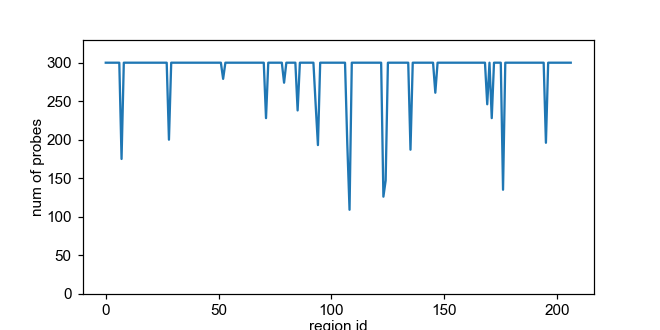

In [30]:
pb_num_dict = {_k:len(_v.kept_probes) for _k,_v in filtered_pb_dict.items()}

pb_nums = np.array(list(pb_num_dict.values()))
plt.figure(figsize=(6,3), dpi=100)
plt.plot(pb_nums)
#plt.plot(np.ones(len(pb_nums))*20)
plt.ylabel(f"num of probes", labelpad=1)
plt.xlabel(f"region id", labelpad=1)
plt.ylim([0, num_probes_kept*1.1])
plt.show()

# 3. Load and asssemble probes

## 3.1 design readout mapping dict (region_to_readout)

load directly from http://localhost:8889/notebooks/Chromatin_Analysis_Scripts/Library_design/CTP-10_Aire/CTP-10_Aire_introns_DNA-MERFISH.ipynb#3.3-assemble-probes

In [32]:
# summarize total readout usage
encoding_folder = os.path.join(pool_folder, f'Genes_intronic_RNA')
gene_2_readout_dict = pickle.load(open(os.path.join(encoding_folder, 'gene_2_readout.pkl'), 'rb'))

## 3.2 loading components

### primers
pick primer set 6,11

In [33]:
primer_folder = r'\\10.245.74.212\Chromatin_NAS_2\Libraries\Primers'
primers = library_tools.assemble.load_primers([6,11], _primer_folder=primer_folder)

- Picked primer: ID: W1A07_primer_6
Name: W1A07_primer_6
Description: W1A07_primer_6
Number of features: 0
Seq('CGCAAACTGGTGCGGAAGGC')
- Picked primer: ID: W1A12_primer_11
Name: W1A12_primer_11
Description: W1A12_primer_11
Number of features: 0
Seq('TAATACGACTCACTATAGGGCCATTGCCCGCGAGGTCGAG')


### readouts

In [34]:
# summarize total readout usage
encoding_folder = os.path.join(pool_folder, f'Genes_intronic_RNA')
gene_2_readout_dict = pickle.load(open(os.path.join(encoding_folder, 'gene_2_readout.pkl'), 'rb'))

In [35]:
# collect types
readout_usage_by_type = {}
for _gene, _infos in gene_2_readout_dict.items():
    for _info in _infos:
        if _info[0] not in readout_usage_by_type:
            readout_usage_by_type[_info[0]] = []
        if int(_info[1:]) not in readout_usage_by_type[_info[0]]:
            readout_usage_by_type[_info[0]].append(int(_info[1:]))

In [37]:
readout_usage_dict = {_type:len(_v) for _type,_v in readout_usage_by_type.items()}
readout_dict ={}

In [50]:
reload(library_tools.assemble)
overwrite_readout_usage = True
readout_folder = r'\\10.245.74.212\Chromatin_NAS_2\Libraries\Readouts'
readout_start = 0
num_color = 2
comb_readouts = library_tools.assemble.load_readouts(readout_usage_dict['c'], 
                                                       _type='snr_after_630', 
                                                       _readout_folder=readout_folder, 
                                                       _num_colors=2, # 750, 647
                                                       _start_id=readout_start,
                                                       )
readout_dict['c'] = comb_readouts

In [51]:
unique_readouts = library_tools.assemble.load_readouts(readout_usage_dict['u'], 
                                                       _type='designed_readouts', 
                                                       _readout_folder=readout_folder, 
                                                       _num_colors=2, # 750, 647
                                                       _start_id=int(sum(list(readout_usage_dict.values()))/2)+1,
                                                       )

readout_dict['u'] = unique_readouts

# save
readout_usage_file = os.path.join(library_folder, 'readout_usage.pkl')
if not os.path.isfile(readout_usage_file) or overwrite_readout_usage:
    print('save')
    pickle.dump(readout_dict, open(readout_usage_file, 'wb'))

save


## 3.3 assemble probes

In [65]:
reload(library_tools.assemble)
from ImageAnalysis3.library_tools.assemble import Assemble_probes

cand_probes, readout_summary = Assemble_probes(library_folder, filtered_pb_dict, 
                                               gene_2_readout_dict, readout_dict, primers, 
                                               primer_len=20, 
                                               num_readout_per_probe=3, 
                                               unique_readout_per_probe=True,
                                               rc_targets=False, overwrite=True)

- Assemble probes by given target sequences, readouts and primers.
-- included readout types: ['u', 'c']
--- assemblying 300 probes in region: Acpp
--- assemblying 300 probes in region: Agt
--- assemblying 300 probes in region: Aldh3a1
--- assemblying 300 probes in region: Aldob
--- assemblying 300 probes in region: Alox5ap
--- assemblying 300 probes in region: Alpi
--- assemblying 300 probes in region: Alpl
--- assemblying 175 probes in region: Ang4
--- assemblying 300 probes in region: Anxa8
--- assemblying 300 probes in region: Apoa1
--- assemblying 300 probes in region: Apoa2
--- assemblying 300 probes in region: Apoc2
--- assemblying 300 probes in region: Apod
--- assemblying 300 probes in region: Ascl1
--- assemblying 300 probes in region: Avil
--- assemblying 300 probes in region: Bgn
--- assemblying 300 probes in region: C1qb
--- assemblying 300 probes in region: C3
--- assemblying 300 probes in region: Calb2
--- assemblying 300 probes in region: Cald1
--- assemblying 300 probe

--- assemblying 300 probes in region: Sst
--- assemblying 300 probes in region: Stxbp5l
--- assemblying 300 probes in region: Syt7
--- assemblying 300 probes in region: Tac1
--- assemblying 300 probes in region: Tac2
--- assemblying 300 probes in region: Tacstd2
--- assemblying 196 probes in region: Tff2
--- assemblying 300 probes in region: Tff3
--- assemblying 300 probes in region: Timp2
--- assemblying 300 probes in region: Tmem45a
--- assemblying 300 probes in region: Tnfrsf11b
--- assemblying 300 probes in region: Trp63
--- assemblying 300 probes in region: Trpm5
--- assemblying 300 probes in region: Tspan1
--- assemblying 300 probes in region: Ttc36
--- assemblying 300 probes in region: Vpreb3
--- assemblying 300 probes in region: Xcl1
--- assemblying 300 probes in region: Zg16
-- 60362 probes assembled in total.
-- saving 60362 probes into file:\\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_TSS_DNA\candidate_probes.fasta
-- saving readout_summary into file:\\10.245.

In [64]:
len(_pb.seq)

160

In [60]:
for _i, _rd in enumerate(comb_readouts):
    if _rd.id == 'NDB_812':
        print(_i)

31


In [61]:
for _i, _rd in enumerate(comb_readouts):
    if _rd.id == 'NDB_860':
        print(_i)

35


In [62]:
for _i, _rd in enumerate(comb_readouts):
    if _rd.id == 'NDB_878':
        print(_i)

45


# 4.Check quality

## 4.1 Load probes

Checking procedures could restart from here

In [63]:
# folder for this library
# candidate full-length probe filename
candidate_basename = 'candidate_probes.fasta' # old version
# load full probes
full_records = []
with open(os.path.join(library_folder, candidate_basename), 'r') as handle:
    for record in SeqIO.parse(handle, "fasta"):
        full_records.append(record)

print(f"Total probe loaded: {len(full_records)}")

Total probe loaded: 60362


In [66]:
num_readout_per_probe = 3
primer_len=20
target_len=40
min_num_probes = 100

### 4.1.1 check primer usage

In [67]:
import ImageAnalysis3.library_tools.quality_check as check
reload(check)
primer_check = check._check_primer_usage(full_records, primers[0], primers[1], primer_len=primer_len)
print(primer_check)

-- Checking primer usage, total probes: 60362
True


### 4.1.2 check region probe number

In [68]:
reload(check)
reg_size_dic, len_check = check._check_region_size(full_records, 
                                                   min_size=min_num_probes)
print(len_check)

gene: Acpp:- -> 300
gene: Agt:- -> 300
gene: Aldh3a1:+ -> 300
gene: Aldob:- -> 300
gene: Alox5ap:+ -> 300
gene: Alpi:- -> 300
gene: Alpl:- -> 300
gene: Ang4:- -> 175
gene: Anxa8:+ -> 300
gene: Apoa1:+ -> 300
gene: Apoa2:+ -> 300
gene: Apoc2:- -> 300
gene: Apod:- -> 300
gene: Ascl1:- -> 300
gene: Avil:+ -> 300
gene: Bgn:+ -> 300
gene: C1qb:- -> 300
gene: C3:- -> 300
gene: Calb2:- -> 300
gene: Cald1:+ -> 300
gene: Camp:- -> 300
gene: Car4:+ -> 300
gene: Car8:- -> 300
gene: Ccdc30:- -> 300
gene: Cck:- -> 300
gene: Ccl1:- -> 300
gene: Ccl2:+ -> 300
gene: Ccl20:+ -> 300
gene: Ccl6:- -> 200
gene: Ccl9:- -> 300
gene: Cd14:- -> 300
gene: Cebpb:+ -> 300
gene: Cga:+ -> 300
gene: Cilp:+ -> 300
gene: Ckb:- -> 300
gene: Ckm:+ -> 300
gene: Clps:- -> 300
gene: Cnfn:- -> 300
gene: Cnmd:- -> 300
gene: Col1a1:+ -> 300
gene: Col4a1:- -> 300
gene: Col6a1:- -> 300
gene: Cpn1:- -> 300
gene: Crabp1:+ -> 300
gene: Cryaa:+ -> 300
gene: Ctrb1:- -> 300
gene: Cxcl13:+ -> 300
gene: Cyp1a2:- -> 300
gene: Cyp2f2:+ -

### 4.1.3 check readout usage for each gene

In [70]:
num_readout_per_probe

3

In [71]:
reload(check)
check_readout_dict = pickle.load(open(os.path.join(library_folder, 'readout_usage.pkl'), 'rb'))

reg_readout_dic, reg2readout_check = check._check_region_to_readouts(full_records, check_readout_dict, 
                                                                     total_readout_num=num_readout_per_probe+1)
print(reg2readout_check)

Acpp:- -> ['NDB_401', 'NDB_812', 'NDB_860', 'NDB_878']
Agt:- -> ['NDB_346', 'NDB_754', 'NDB_773', 'NDB_817']
Aldh3a1:+ -> ['NDB_608', 'NDB_860', 'NDB_961', 'NDB_974']
Aldob:- -> ['NDB_376', 'NDB_743', 'NDB_844', 'NDB_863']
Alox5ap:+ -> ['NDB_340', 'NDB_634', 'NDB_971', 'NDB_1033']
Alpi:- -> ['NDB_595', 'NDB_844', 'NDB_860', 'NDB_865']
Alpl:- -> ['NDB_584', 'NDB_713', 'NDB_856', 'NDB_971']
Ang4:- -> ['NDB_589', 'NDB_715', 'NDB_754', 'NDB_860']
Anxa8:+ -> ['NDB_419', 'NDB_680', 'NDB_728', 'NDB_901']
Apoa1:+ -> ['NDB_382', 'NDB_773', 'NDB_917', 'NDB_971']
Apoa2:+ -> ['NDB_566', 'NDB_631', 'NDB_643', 'NDB_773']
Apoc2:- -> ['NDB_523', 'NDB_683', 'NDB_790', 'NDB_865']
Apod:- -> ['NDB_497', 'NDB_737', 'NDB_773', 'NDB_844']
Ascl1:- -> ['NDB_326', 'NDB_661', 'NDB_698', 'NDB_773']
Avil:+ -> ['NDB_338', 'NDB_653', 'NDB_743', 'NDB_815']
Bgn:+ -> ['NDB_572', 'NDB_680', 'NDB_784', 'NDB_971']
C1qb:- -> ['NDB_581', 'NDB_698', 'NDB_826', 'NDB_875']
C3:- -> ['NDB_331', 'NDB_778', 'NDB_875', 'NDB_971']
C

### 4.1.4 check readout usage in the library

In [73]:
reload(check)
readout_reg_dic, readout2reg_check = check._check_readout_to_region(reg_readout_dic, full_records, 
                                                                    check_readout_dict, primer_len=primer_len, 
                                                                    target_len=target_len,
                                                                    probe_readout_num=num_readout_per_probe+1)

print(readout2reg_check)

-- extracting probes from >region:Acpp:-, region:Agt:-, region:Aldh3a1:+, region:Aldob:-, region:Alox5ap:+, region:Alpi:-, region:Alpl:-, region:Ang4:-, region:Anxa8:+, region:Apoa1:+, region:Apoa2:+, region:Apoc2:-, region:Apod:-, region:Ascl1:-, region:Avil:+, region:Bgn:+, region:C1qb:-, region:C3:-, region:Calb2:-, region:Cald1:+, region:Camp:-, region:Car4:+, region:Car8:-, region:Ccdc30:-, region:Cck:-, region:Ccl1:-, region:Ccl2:+, region:Ccl20:+, region:Ccl6:-, region:Ccl9:-, region:Cd14:-, region:Cebpb:+, region:Cga:+, region:Cilp:+, region:Ckb:-, region:Ckm:+, region:Clps:-, region:Cnfn:-, region:Cnmd:-, region:Col1a1:+, region:Col4a1:-, region:Col6a1:-, region:Cpn1:-, region:Crabp1:+, region:Cryaa:+, region:Ctrb1:-, region:Cxcl13:+, region:Cyp1a2:-, region:Cyp2f2:+, region:Dbn1:-, region:Dclk1:+, region:Dlk1:+, region:Dppa3:+, region:Ecm1:-, region:Efna3:-, region:Elovl4:-, region:Fabp1:+, region:Fabp6:-, region:Fam183b:-, region:Fam25c:-, region:Fgg:+, region:Foxa1:-, regio

### 4.1.5 check bewteen probes

In [78]:
# construct internal map
reload(check)
int_map = check._construct_internal_map(full_records, library_folder) 

-- saving internal 17-mer map to file:\\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_TSS_DNA\probe_table_17.npz


In [79]:
# internal check probes
readout_count_dic, readout_count_check = check._check_readout_in_probes(readout_reg_dic, reg_size_dic, int_map, readout_dict)
print(readout_count_check)

True


In [80]:
# check between probes
kept_records, removed_count = check._check_between_probes(full_records, int_map, 
                                                          primer_len=primer_len, target_len=target_len)

--- Sequence:loc_4:8224041-8254041_gene_Car8:-_pb_243_pos_23900_strand_-_readouts_[NDB_631_c,NDB_631_c,NDB_631_c,NDB_631_c] got hits:52, dumped
--- Sequence:loc_4:8224041-8254041_gene_Car8:-_pb_269_pos_26158_strand_-_readouts_[NDB_847_c,NDB_847_c,NDB_847_c,NDB_847_c] got hits:51, dumped
--- Sequence:loc_9:121480694-121510694_gene_Cck:-_pb_46_pos_4608_strand_+_readouts_[NDB_716_c,NDB_716_c,NDB_716_c,NDB_716_c] got hits:89, dumped
--- Sequence:loc_9:121480694-121510694_gene_Cck:-_pb_47_pos_4657_strand_+_readouts_[NDB_883_c,NDB_883_c,NDB_883_c,NDB_883_c] got hits:60, dumped
--- Sequence:loc_9:121480694-121510694_gene_Cck:-_pb_48_pos_4717_strand_+_readouts_[NDB_487_u,NDB_487_u,NDB_487_u,NDB_487_u] got hits:89, dumped
--- Sequence:loc_9:121480694-121510694_gene_Cck:-_pb_49_pos_4791_strand_-_readouts_[NDB_875_c,NDB_875_c,NDB_875_c,NDB_875_c] got hits:60, dumped
--- Sequence:loc_9:121480694-121510694_gene_Cck:-_pb_51_pos_4903_strand_+_readouts_[NDB_883_c,NDB_883_c,NDB_883_c,NDB_883_c] got hit

--- Sequence:loc_2:3407648-3437648_gene_Meig1:-_pb_27_pos_3473_strand_-_readouts_[NDB_863_c,NDB_863_c,NDB_863_c,NDB_863_c] got hits:68, dumped
--- Sequence:loc_2:3407648-3437648_gene_Meig1:-_pb_28_pos_3518_strand_-_readouts_[NDB_431_u,NDB_431_u,NDB_431_u,NDB_431_u] got hits:68, dumped
--- Sequence:loc_2:3407648-3437648_gene_Meig1:-_pb_30_pos_3619_strand_-_readouts_[NDB_778_c,NDB_778_c,NDB_778_c,NDB_778_c] got hits:73, dumped
--- Sequence:loc_2:3407648-3437648_gene_Meig1:-_pb_35_pos_4017_strand_+_readouts_[NDB_863_c,NDB_863_c,NDB_863_c,NDB_863_c] got hits:114, dumped
--- Sequence:loc_2:3407648-3437648_gene_Meig1:-_pb_36_pos_4078_strand_-_readouts_[NDB_431_u,NDB_431_u,NDB_431_u,NDB_431_u] got hits:162, dumped
--- Sequence:loc_2:3407648-3437648_gene_Meig1:-_pb_37_pos_4133_strand_-_readouts_[NDB_643_c,NDB_643_c,NDB_643_c,NDB_643_c] got hits:132, dumped
--- Sequence:loc_2:3407648-3437648_gene_Meig1:-_pb_38_pos_4185_strand_+_readouts_[NDB_778_c,NDB_778_c,NDB_778_c,NDB_778_c] got hits:149, du

In [81]:
del(int_map)

### 4.1.6 finish checking, save

In [82]:
# save kept records
with open(os.path.join(library_folder, 'filtered_full_probes.fasta'), 'w') as output_handle:
    SeqIO.write(kept_records, output_handle, "fasta")

## 4.2 BLAST screening of probes

create the local blast database by:
```bash
makeblastdb -in C:\Users\puzheng\Documents\Tools\lowercase_masked\Mus_musculus.GRCm38.dna_sm.merged.fa -dbtype nucl -parse_seqids -out GRCm38_ensembl -title "Mouse chromosomes soft masked" -blastdb_version 4![image.png](attachment:image.png)
```

The outputs are:
```bash
Building a new DB, current time: 03/30/2021 21:49:18
New DB name:   C:\Users\puzheng\Documents\Tools\GRCm38_ensembl
New DB title:  Mouse chromosomes soft masked
Sequence type: Nucleotide
Keep MBits: T
Maximum file size: 1000000000B
Adding sequences from FASTA; added 66 sequences in 42.2668 seconds.
```

In [ ]:
blast_database = os.path.join(reference_folder, 'blast_database', 'GRCm38_ensembl')

check.Blast_probes(kept_records, library_folder, num_threads=20, 
                   blast_db=blast_database)

- Blast probe against \\10.245.74.212\Chromatin_NAS_2\Libraries\Genomes\mouse\GRCm38_ensembl\blast_database\GRCm38_ensembl
-- number of probes loaded: 60243
-- processing region: Acpp:- with 300 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_TSS_DNA\blast\probe_gene_Acpp:-.fasta
--- *blasting region: Acpp:-
--- total time for blast Acpp:-: 165.2680013179779
-- processing region: Agt:- with 300 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_TSS_DNA\blast\probe_gene_Agt:-.fasta
--- *blasting region: Agt:-
--- total time for blast Agt:-: 299.73527455329895
-- processing region: Aldh3a1:+ with 300 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_TSS_DNA\blast\probe_gene_Aldh3a1:+.fasta
--- *blasting region: Aldh3a1:+
--- total time for blast Aldh3a1:+: 217.5090012550354
-- processing region: Aldob:- with 300 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Libraries\C

### 4.2.1 screen probe by blast results

This step has 2 different cutoffs:

hard_cutoff: whether a probe has any ~40mer hit somewhere else, if so just dump the probe

soft_cutoff: whether a probe has a lot of ~20mer off-target hits, if exceed certain amount then dump the probe

In [ ]:
# screen
num_probes_per_region = 300
kept_pbs, blast_keep_dic, hard_count_list, soft_count_list = check.Screening_Probes_by_Blast(library_folder, 
                                                                                             num_probes_per_region,
                                                                                             hard_thres=target_len,
                                                                                             soft_count_th=50,
                                                                                             )